# Load data

In [1]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

EXPERIMENT_NAME = "January 2022 to December 2024"
EXPERIMENT_DESCRIPTION = "January 2025 fire period with PWWB, Airnow, and HRRR data."
EXPERIMENT_ID = "two_years_pwwb_airnow_hrrr"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"
TRAIN_SPLIT = 0.70
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15

# Model parameters
EPOCHS = 100
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
LEARNING_RATE = 0.0001

all_channel_names = ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25', 'HRRR_COLMD']

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: January 2022 to December 2024
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date Range: 2022-12-01-00 to 2024-12-01-00
Train/Test Split: 70%/30% (temporal)


In [2]:
# load train test and valid files
print("Loading testing files...")

test_files = ["MAIAC_AOD_X_test.npy", "TROPOMI_NO2_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy"]

data_size = [
    os.path.getsize(f"final_input_data/two_years_with_hrrr/{file}") 
    for file in test_files
]
print(f"Total size of data that will be loaded in RAM: {sum(data_size) * 1e-9:.2f}GB\n")

print("Loading numpy arrays...")
X_test_scaled = np.stack([np.load(f"final_input_data/two_years_with_hrrr/{file}") for file in test_files], axis=-1)
Y_test = np.load("final_input_data/two_years_with_hrrr/Y_test.npy")

print("Data successfully loaded.")

Loading testing files...
Total size of data that will be loaded in RAM: 1.01GB

Loading numpy arrays...
Data successfully loaded.


In [3]:
# Debug cell to check channel names and data shapes
print("=== DEBUGGING CHANNEL INFORMATION ===")
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"X_train_scaled shape: {X_test_scaled.shape}")
print(f"Number of channels in data: {X_test_scaled.shape[4]}")
print(f"Number of channel names provided: {len(all_channel_names)}")
print(f"Channel names length matches data channels: {len(all_channel_names) == X_test_scaled.shape[4]}")
print()

print("Channel names provided:")
for i, name in enumerate(all_channel_names):
    print(f"  {i}: {name}")
print()

print("What the visualization function will use:")
n_channels = X_test_scaled.shape[4]
if all_channel_names is None or len(all_channel_names) != n_channels:
    effective_channel_names = [f"Channel {i}" for i in range(n_channels)]
    print("  Using GENERIC channel names (this is the problem!):")
else:
    effective_channel_names = all_channel_names
    print("  Using PROVIDED channel names:")

for i, name in enumerate(effective_channel_names):
    print(f"  {i}: {name}")
print()

print("=== DATA SAMPLE CHECK ===")
# Check what's actually in the first few channels
sample_idx = 42  # Use same sample as visualization
for c in range(min(3, n_channels)):  # Check first 3 channels
    data = X_test_scaled[sample_idx, 0, :, :, c]  # First frame
    print(f"Channel {c} ({effective_channel_names[c] if c < len(effective_channel_names) else 'Unknown'}):")
    print(f"  Min: {data.min():.6f}, Max: {data.max():.6f}, Mean: {data.mean():.6f}")
    print()

=== DEBUGGING CHANNEL INFORMATION ===
Experiment name: January 2022 to December 2024
X_train_scaled shape: (2631, 5, 40, 40, 6)
Number of channels in data: 6
Number of channel names provided: 6
Channel names length matches data channels: True

Channel names provided:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25
  5: HRRR_COLMD

What the visualization function will use:
  Using PROVIDED channel names:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25
  5: HRRR_COLMD

=== DATA SAMPLE CHECK ===
Channel 0 (MAIAC_AOD):
  Min: -1.048153, Max: 1.898079, Mean: 0.314288

Channel 1 (TROPOMI_NO2):
  Min: -0.909231, Max: 1.187532, Mean: -0.332034

Channel 2 (METAR_Wind_U):
  Min: -0.576410, Max: -0.281264, Mean: -0.413731



In [4]:
# Function to visualize data from experiment
np.random.seed(42)
def visualize_experiment_data(X, Y, channel_names=None, sample_idx=None, experiment_name="Experiment"):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        channel_name = channel_names[c] if c < len(channel_names) else f"Channel {c}"
        
        for f in range(n_frames):
            ax = axes[c, f]
            data = X[sample_idx, f, :, :, c]
            
            im = ax.imshow(data)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_name)
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"{experiment_name}\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if Y is not None:
        print(f"Target values: {Y[sample_idx]}")

Visualizing data for January 2022 to December 2024...


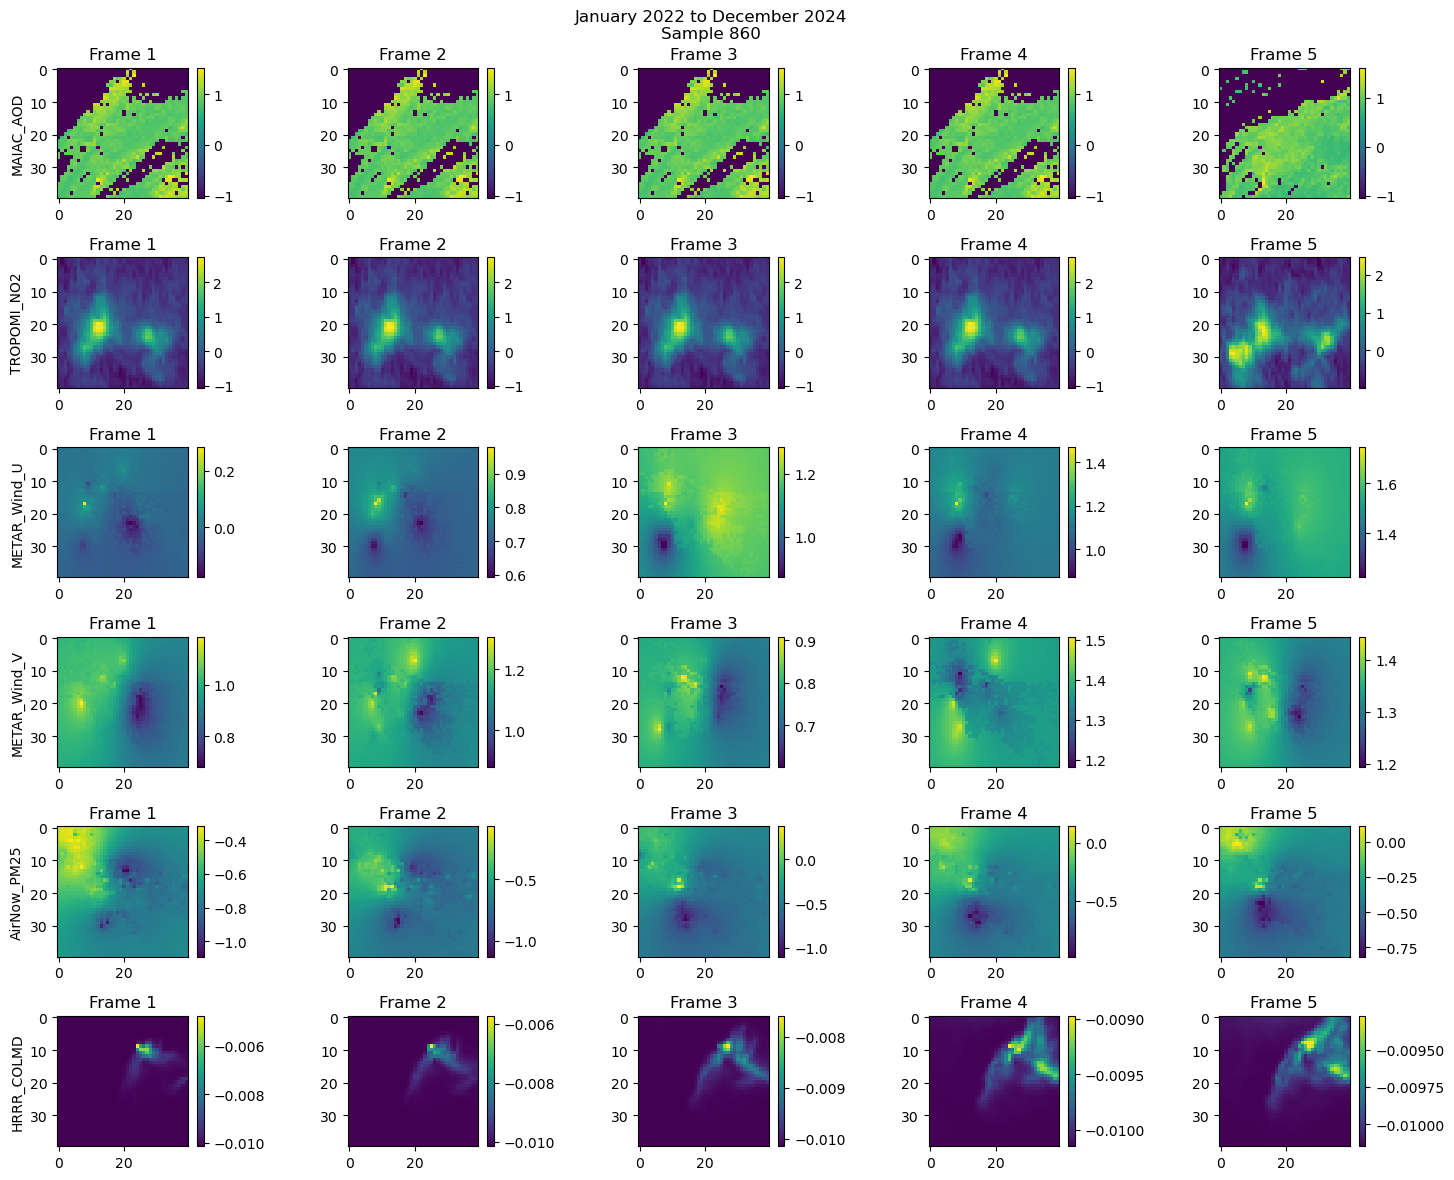

Target values: [[ 6.4  8.2 10.6  8.4  9.4  4.5  5.9  6.9]
 [ 5.2  8.6 10.2  8.4  7.7  4.2  9.4  8.5]
 [ 5.6  7.1 11.3  5.9  6.7  5.8  8.1  8.1]
 [ 5.8  6.2  9.8  4.1  8.8  6.1  7.1  6.2]
 [ 5.4  6.2  9.5  5.5  8.9  6.1  5.9  5.3]]


In [5]:
# Run the visualization  
print(f"Visualizing data for {EXPERIMENT_NAME}...")
visualize_experiment_data(X_test_scaled, Y_test, channel_names=all_channel_names, experiment_name=EXPERIMENT_NAME)

# Baseline Analysis

In [6]:
import sys
sys.path.append("../..")
from libs.plotting import comprehensive_frame_analysis

# Get sensor names
sensor_names = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 
    'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel'
]

(2631, 5, 8) (2631, 5, 8)
[[ 7.8  8.5 12.1  9.8  7.9  4.7  6.9 12.1]
 [ 9.8  8.4 12.3 10.2  8.5  4.4  6.5 14.8]
 [ 8.9 10.8 12.1 10.   8.5  4.6  7.9 15.5]
 [ 7.4 11.2 10.9 10.9  8.3  7.1  8.1 17. ]
 [ 6.7 13.2 11.4 12.2  8.7  8.5  6.3 14.4]]
[[ 7.8  8.5 12.1  9.8  7.9  4.7  6.9 12.1]
 [ 9.8  8.4 12.3 10.2  8.5  4.4  6.5 14.8]
 [ 8.9 10.8 12.1 10.   8.5  4.6  7.9 15.5]
 [ 7.4 11.2 10.9 10.9  8.3  7.1  8.1 17. ]
 [ 6.7 13.2 11.4 12.2  8.7  8.5  6.3 14.4]]
🎯 COMPREHENSIVE CONVLSTM PERFORMANCE ANALYSIS
📊 Analyzing 5 frames (hours) across 8 sensors
📈 Dataset: 2631 samples

This analysis evaluates ConvLSTM's ability to predict air quality across multiple future time frames
and spatial locations, revealing critical spatio-temporal prediction patterns.

📊 1. FRAME-BY-FRAME RMSE
────────────────────────────────────────────────────────────
📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently

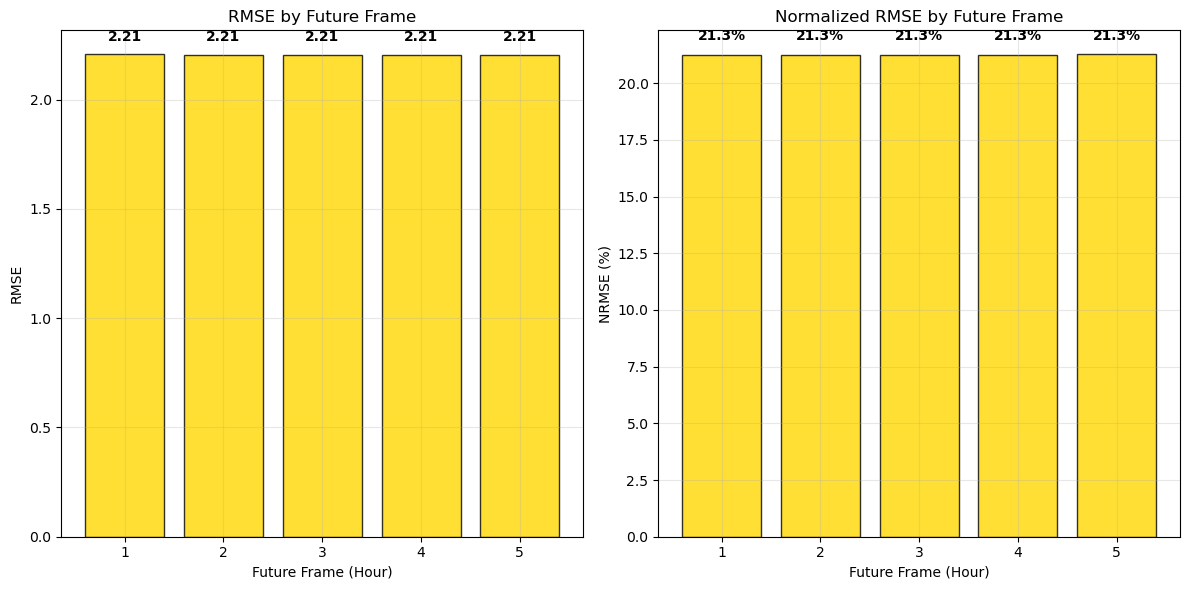


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.206 (21.3%)
Hour 2: RMSE = 2.206 (21.3%)
Hour 3: RMSE = 2.206 (21.3%)
Hour 4: RMSE = 2.206 (21.3%)
Hour 5: RMSE = 2.206 (21.3%)

📍 2. AVERAGE RMSE PER STATION (ALL HOURS)
───────────────────────────────────────────────────────
📍 SPATIAL PERFORMANCE ANALYSIS
This identifies which monitoring stations are consistently difficult for ConvLSTM to predict.
Challenging stations often have complex local meteorology or unique pollution sources.



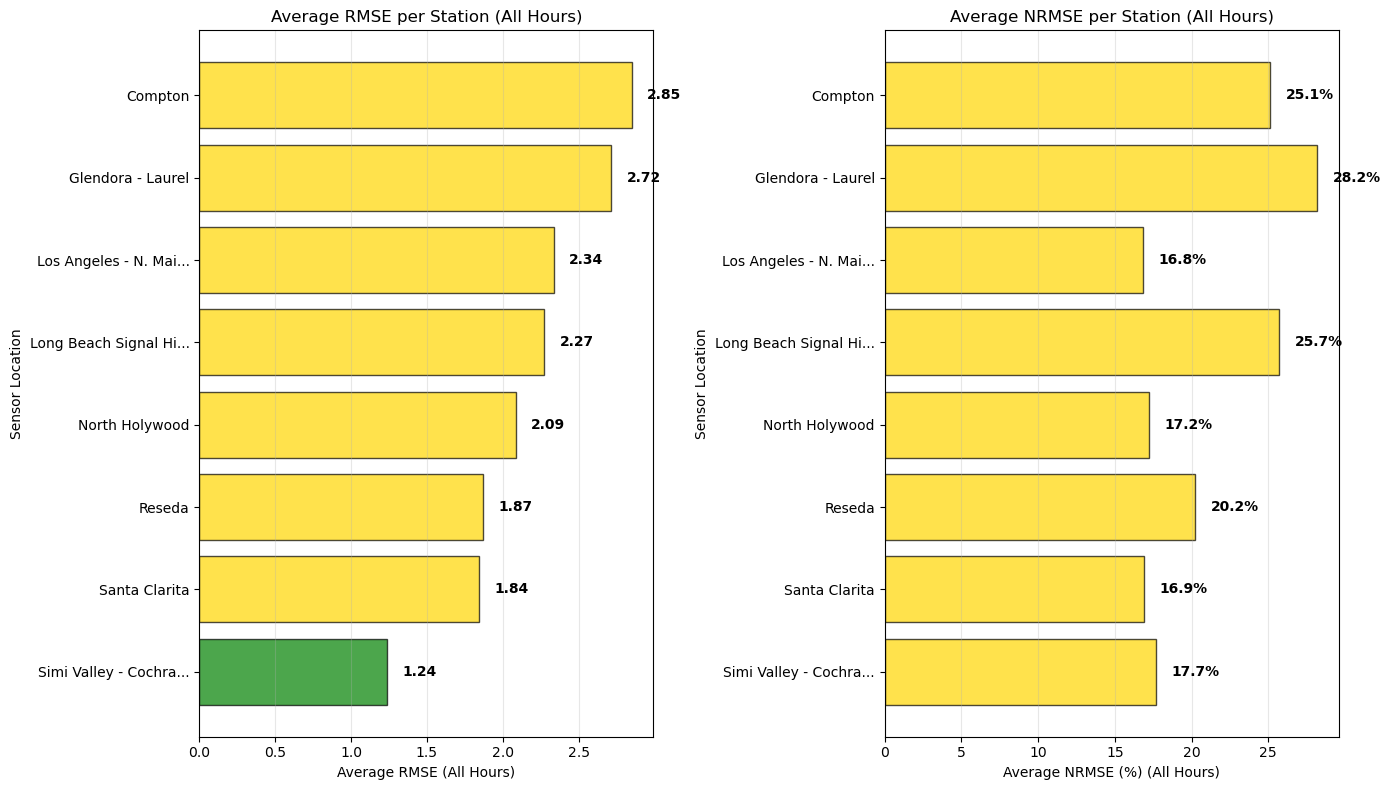


📍 STATION PERFORMANCE SUMMARY (All Hours Combined)

🟢 EXCELLENT Stations (RMSE < 1.5): 1
   • Simi Valley - Cochran Street: 1.240

🟡 GOOD Stations (1.5-3.0): 7
   • Santa Clarita: 1.845
   • Reseda: 1.871
   • North Holywood: 2.087
   • Long Beach Signal Hill: 2.274
   • Los Angeles - N. Main Street: 2.338
   • Glendora - Laurel: 2.716
   • Compton: 2.850

🟠 FAIR Stations (3.0-5.0): 0

🔴 POOR Stations (≥ 5.0): 0

📊 SUMMARY STATISTICS:
   🏆 Best Station:  Simi Valley - Cochran Street (RMSE: 1.240)
   💥 Worst Station: Compton (RMSE: 2.850)
   📈 Average RMSE:  2.152
   📏 RMSE Range:    1.610
   🎯 Reliability:   8/8 stations ≤ 3.0 RMSE

📊 SUMMARY TABLE - RMSE BY HOUR AND SENSOR
Sensor                   │ Hour 1 │ Hour 2 │ Hour 3 │ Hour 4 │ Hour 5 │  Avg   
─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────
Simi Valley - Cochran St │  1.24  │  1.24  │  1.24  │  1.24  │  1.24  │  1.24  
Reseda                   │  1.87  │  1.87  │  1.87  │  1.87  │  1.87  │  1.8

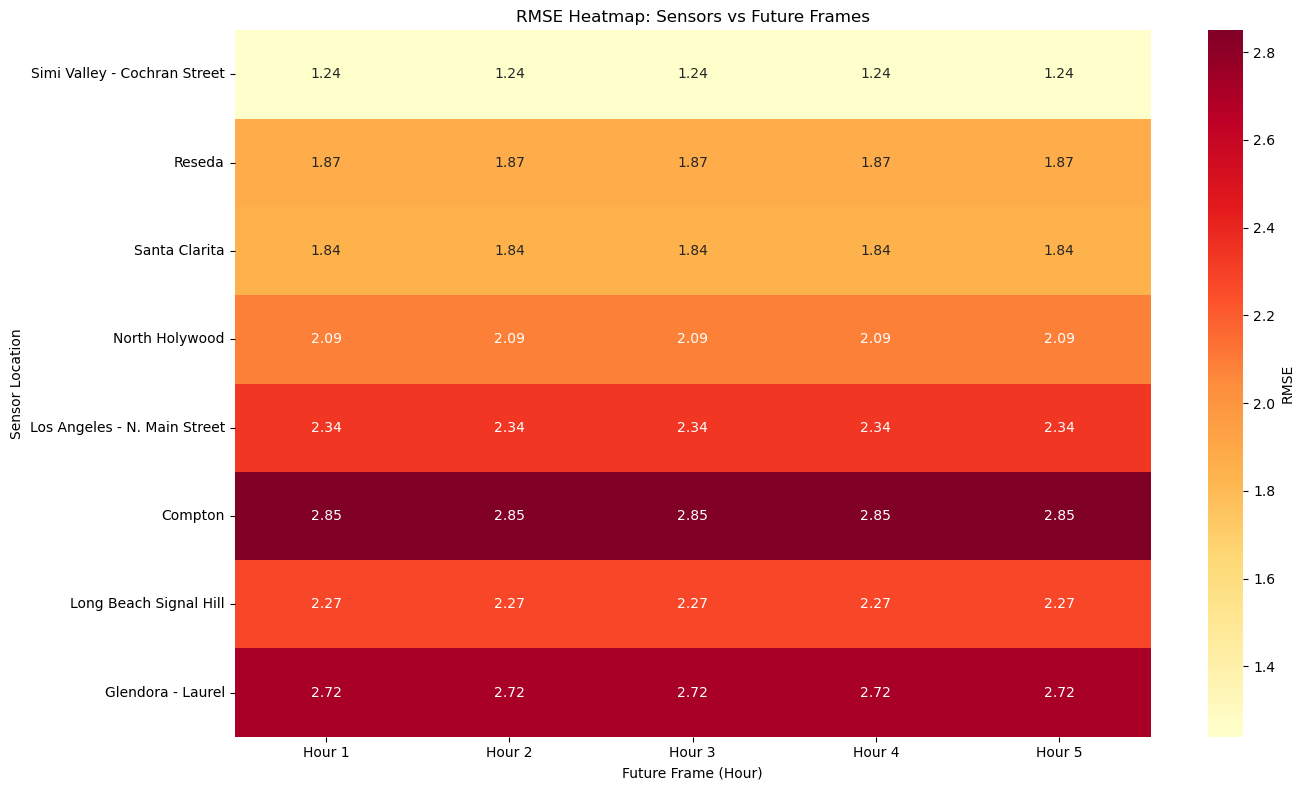


🔥 WORST PERFORMING COMBINATIONS:
Compton at Hour 1: RMSE = 2.850
Compton at Hour 4: RMSE = 2.850
Compton at Hour 2: RMSE = 2.850
Compton at Hour 3: RMSE = 2.850
Compton at Hour 5: RMSE = 2.849

📈 4. TIME SERIES BY FRAME
───────────────────────────────────
Temporal pattern analysis

🕐 Hour 1 Time Series


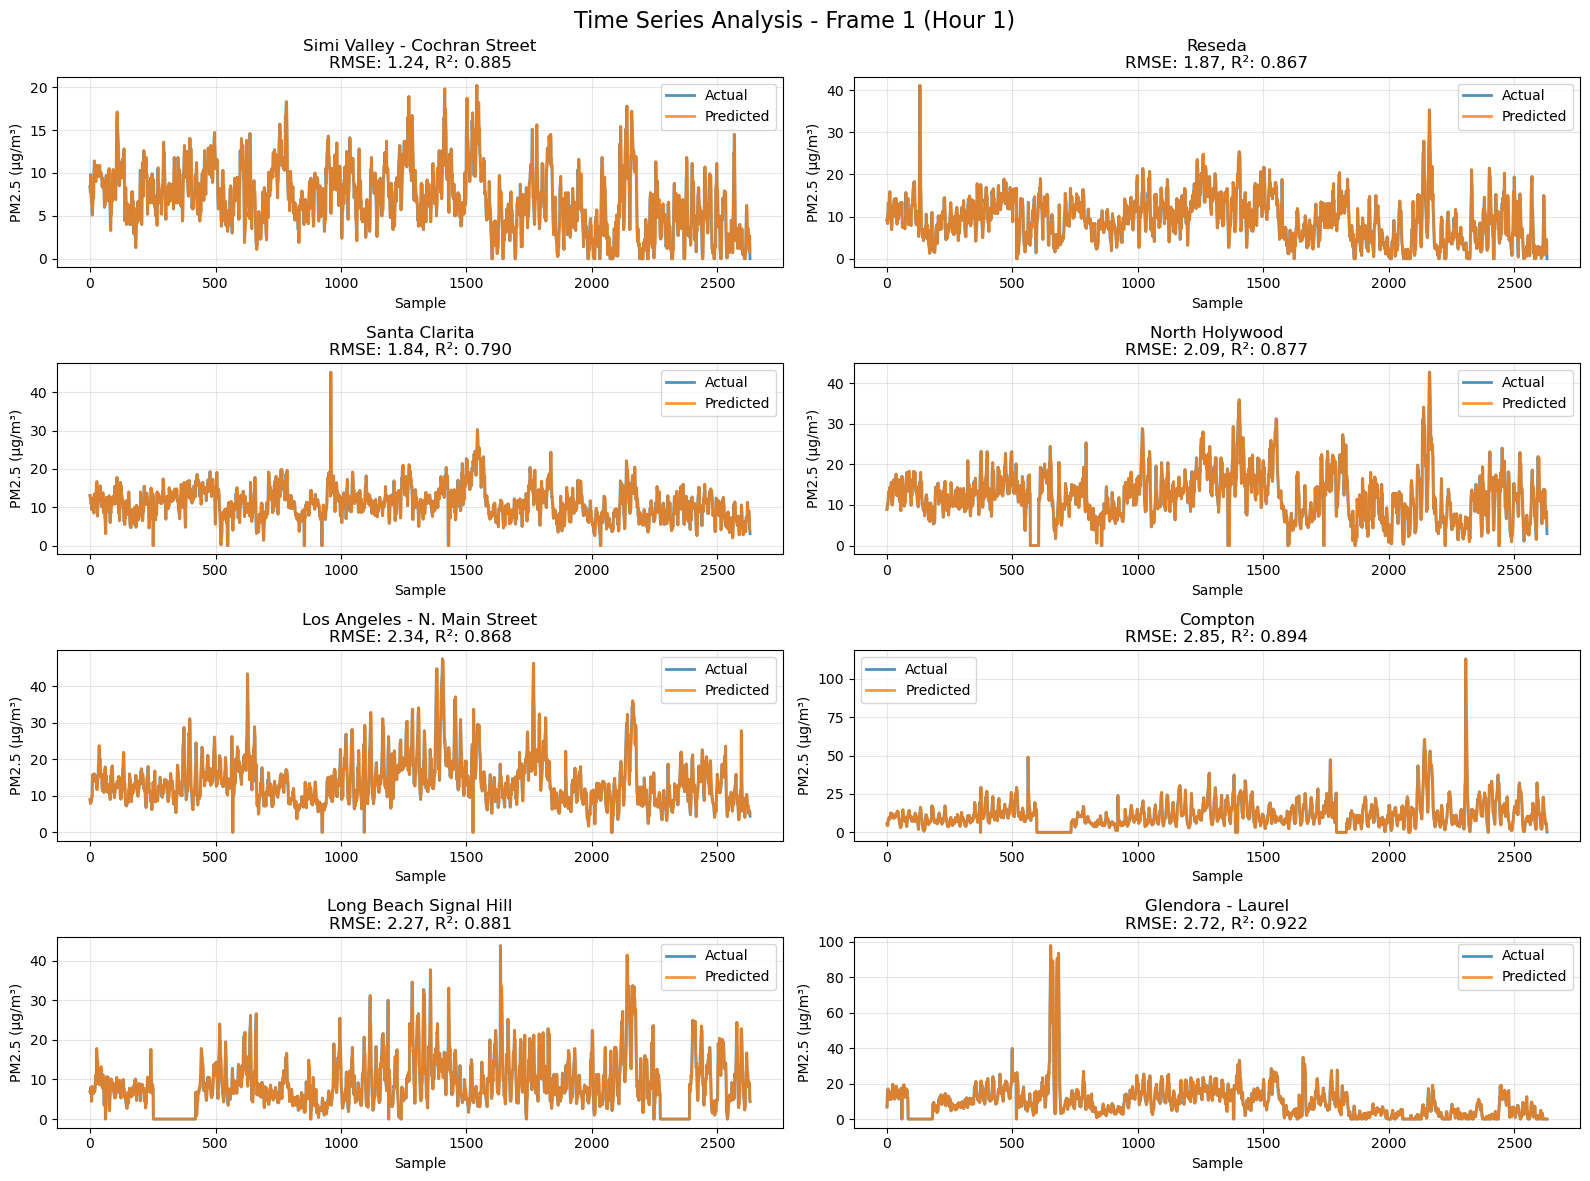


🕐 Hour 2 Time Series


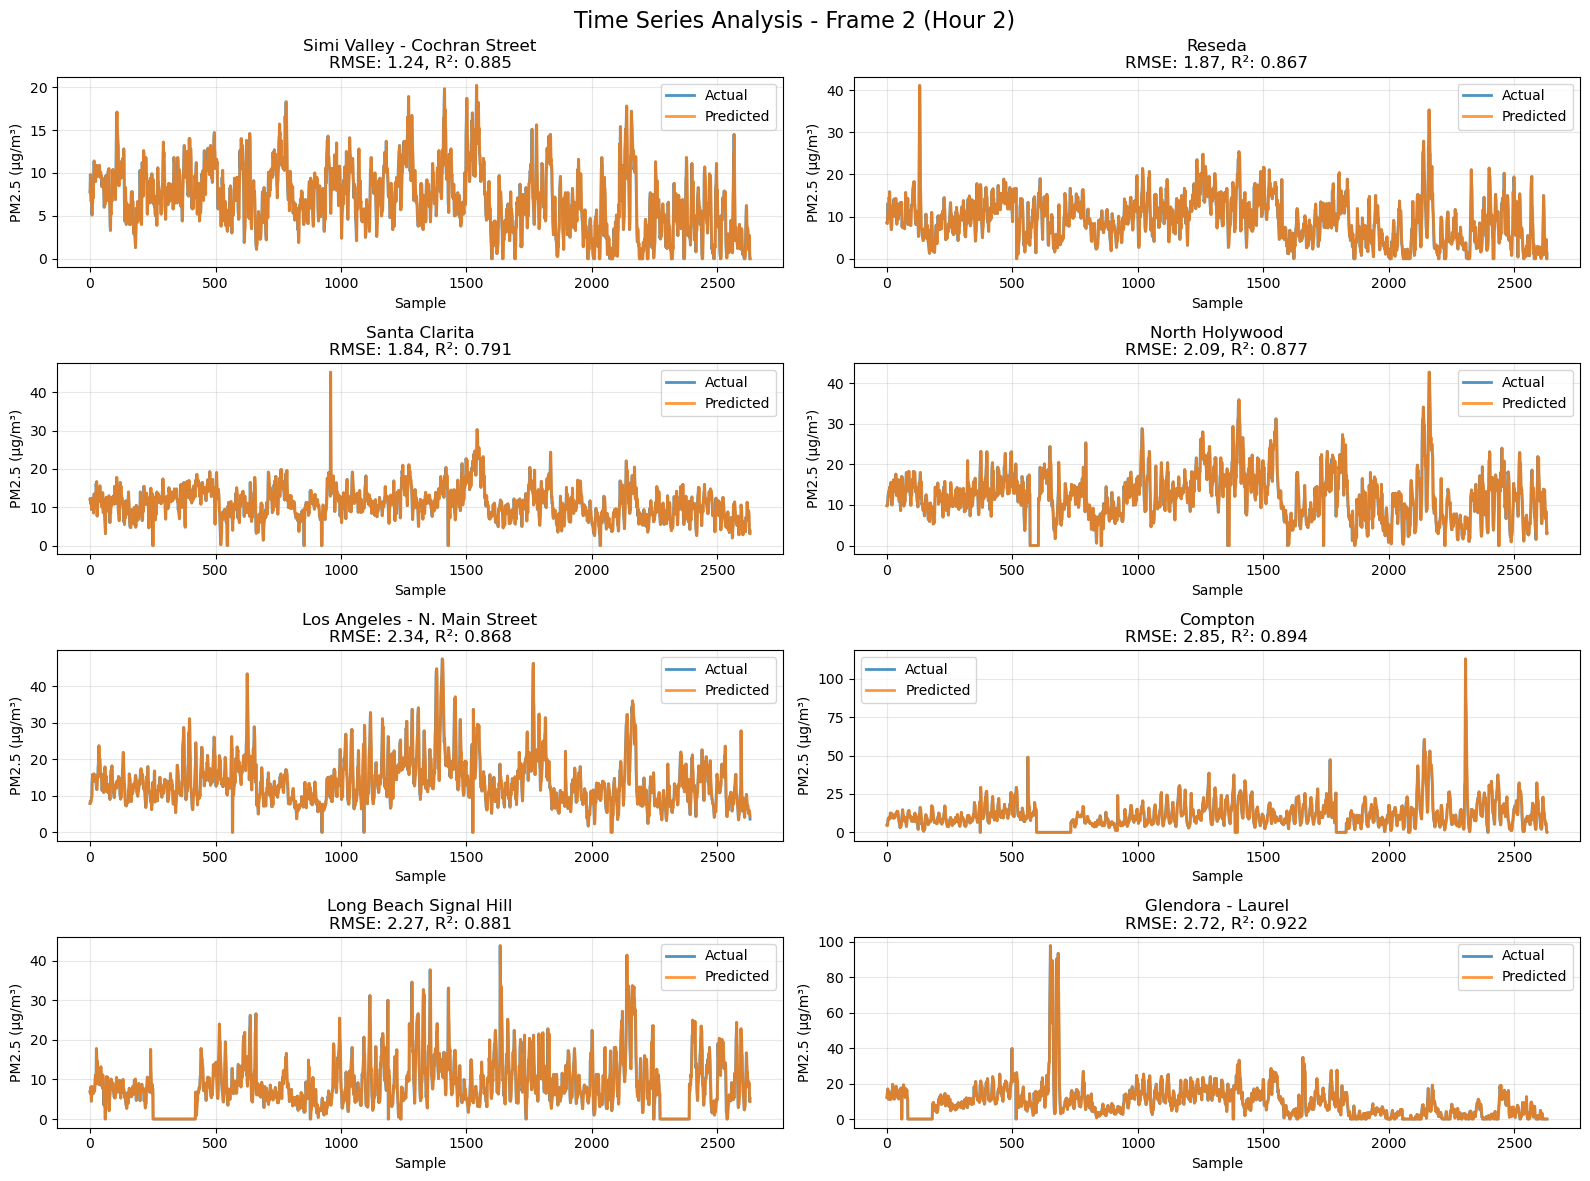


🕐 Hour 3 Time Series


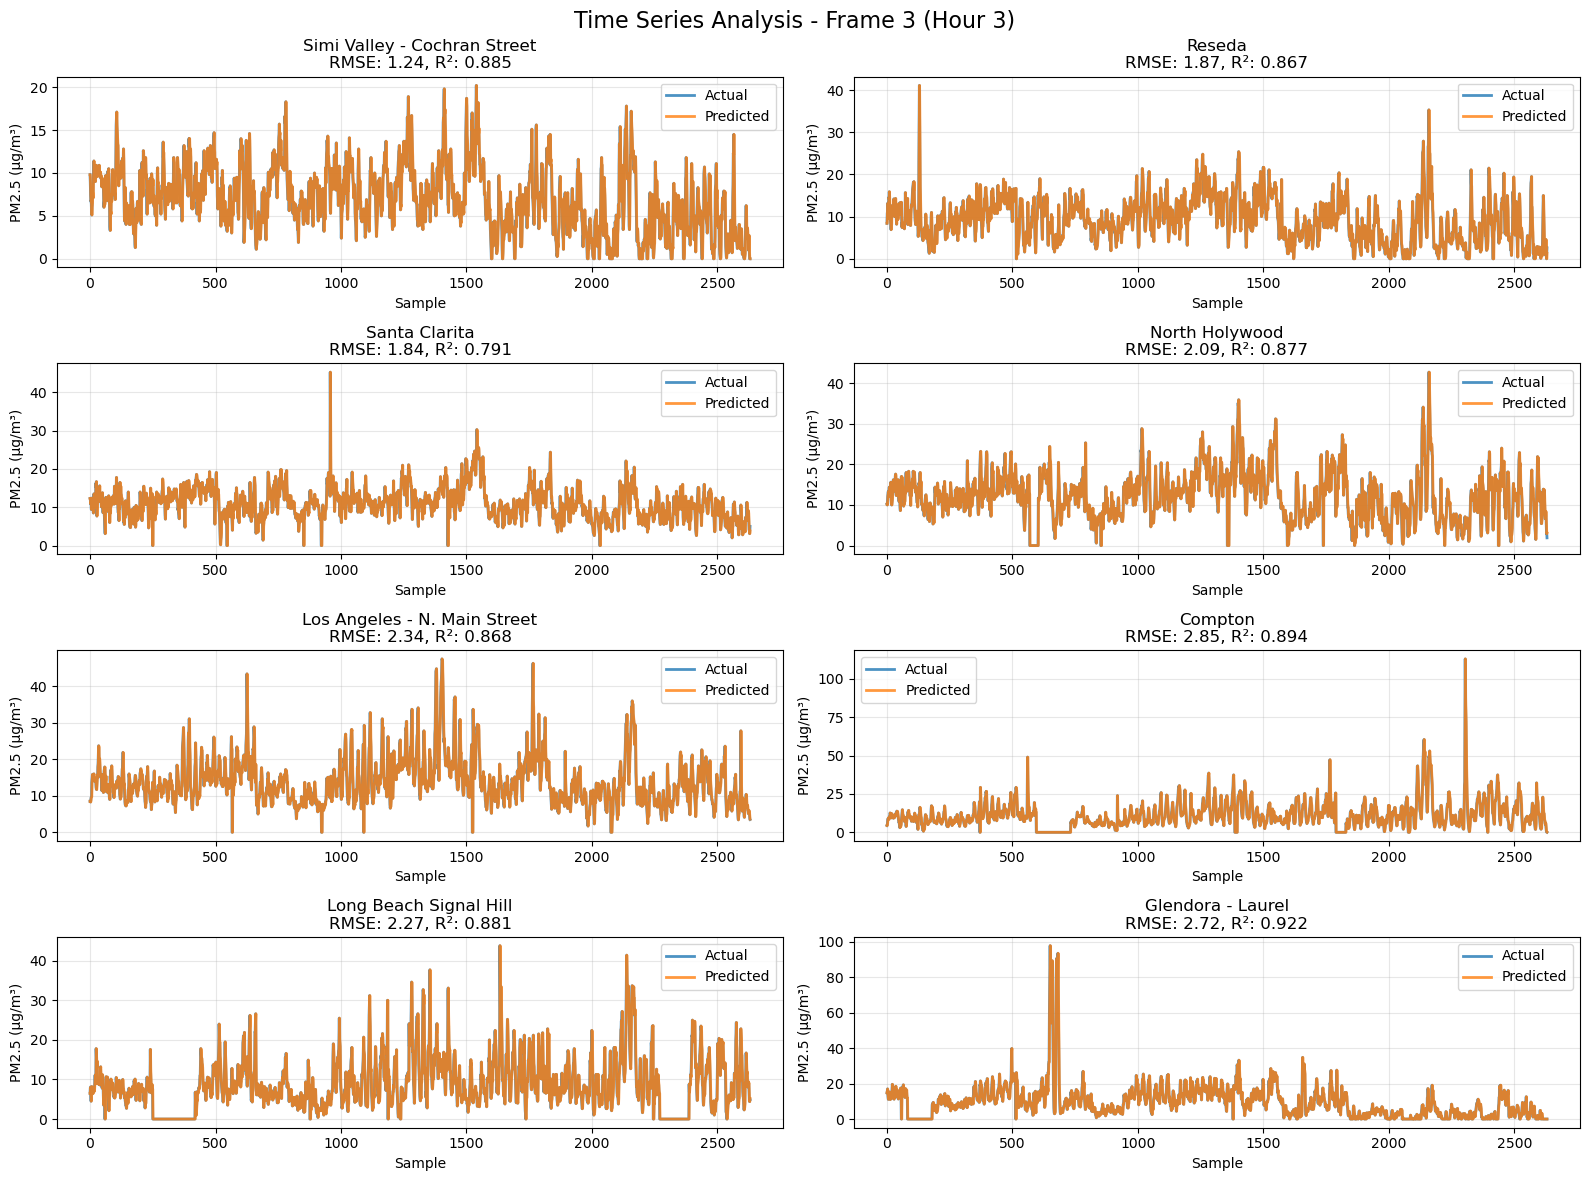


🕐 Hour 4 Time Series


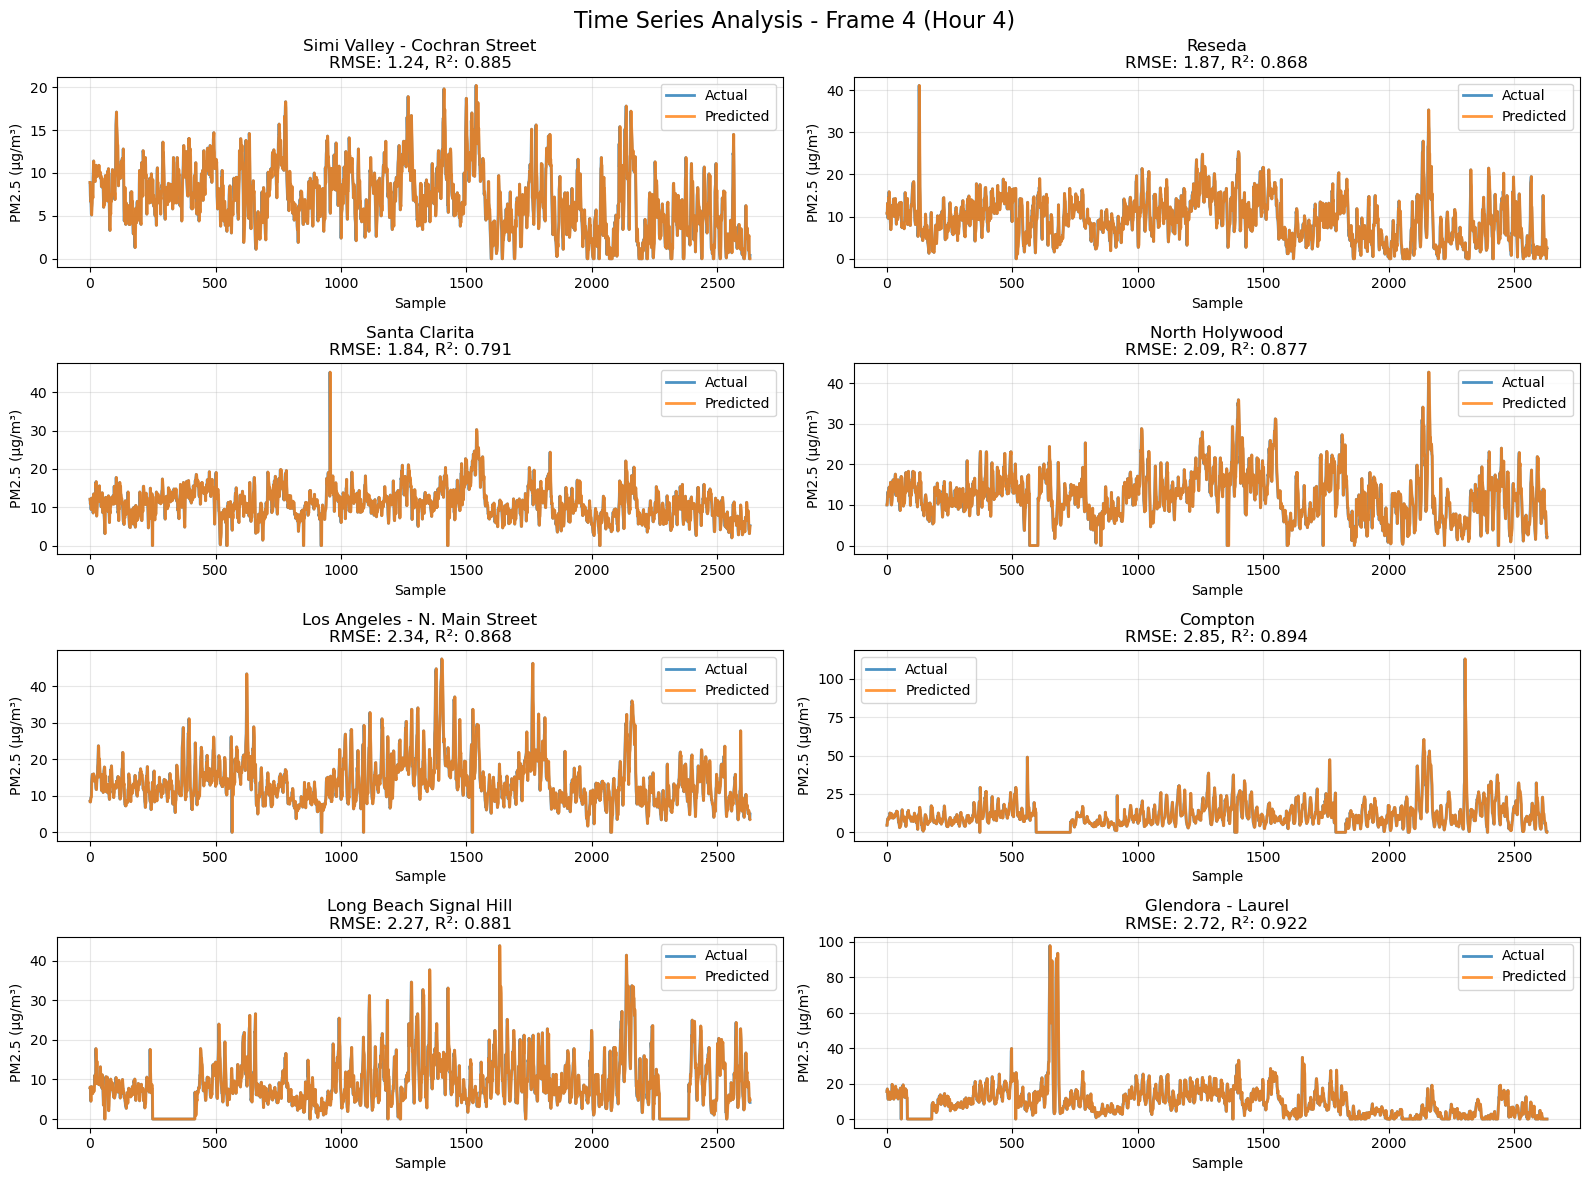


🕐 Hour 5 Time Series


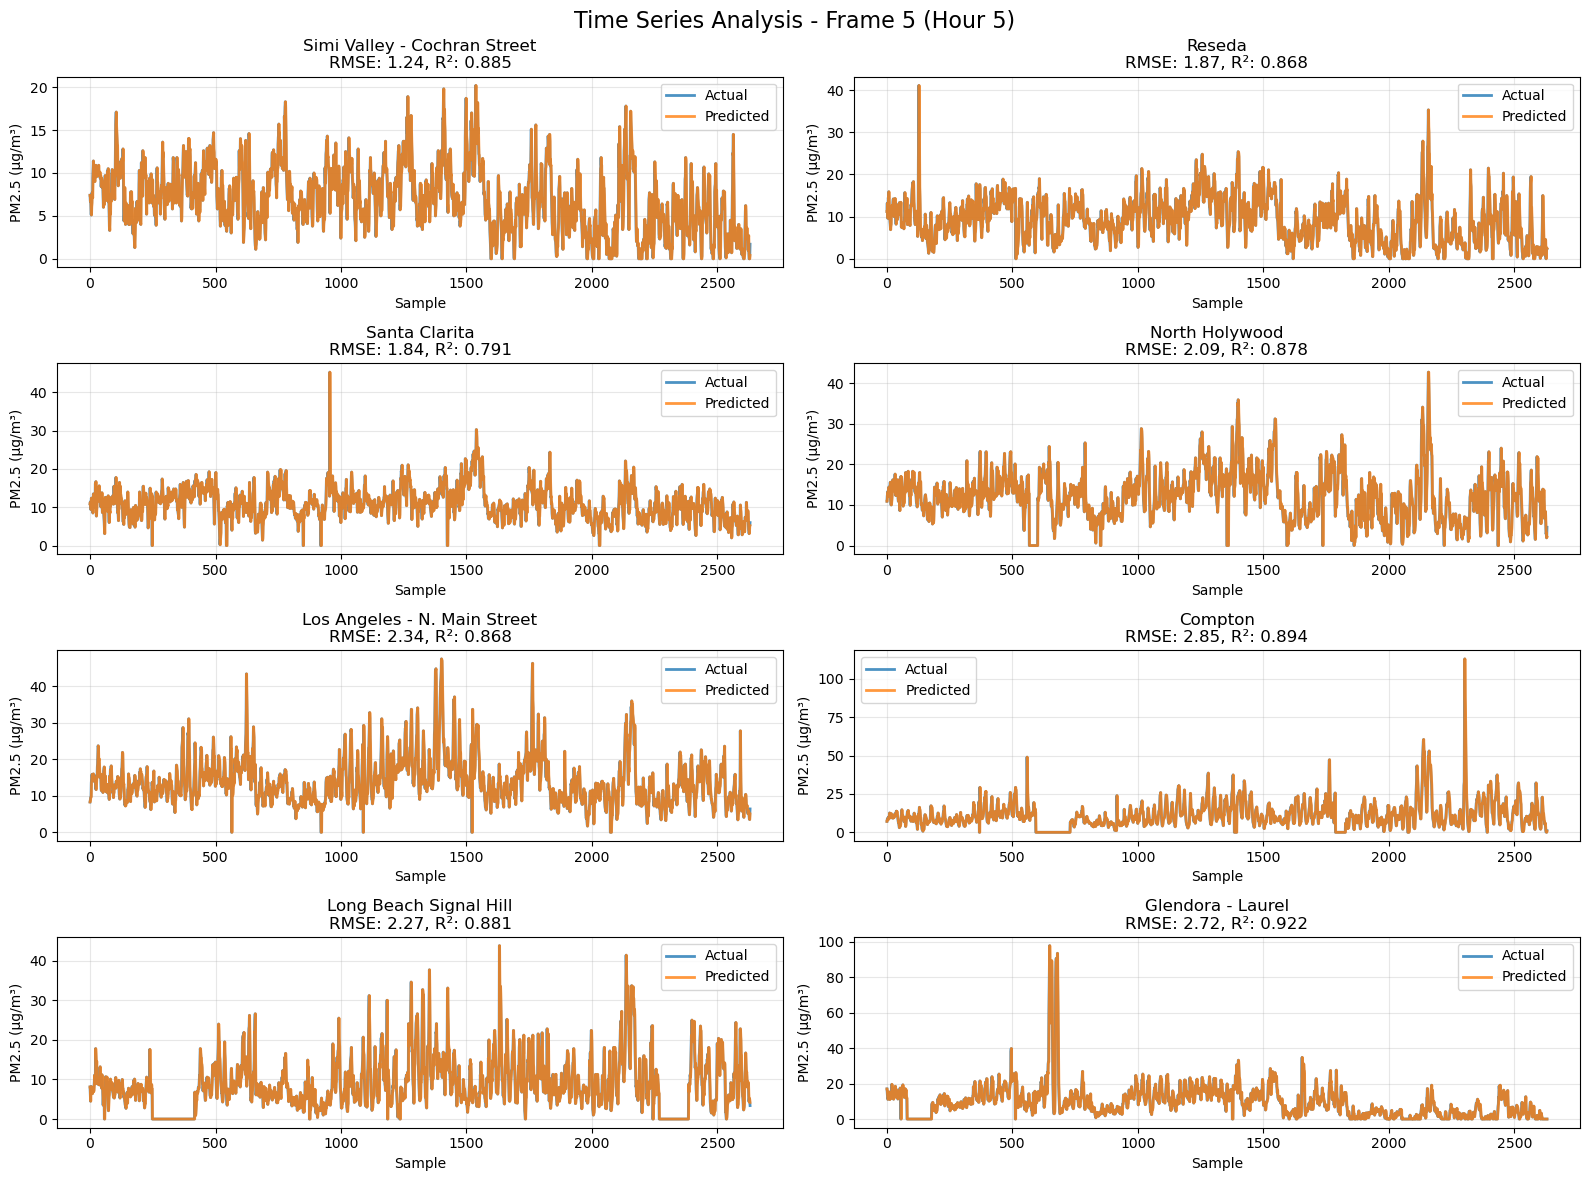


🎯 5. SCATTER PLOTS BY FRAME
───────────────────────────────────
Prediction accuracy assessment for each time frame:

🎯 Hour 1 Scatter Plot


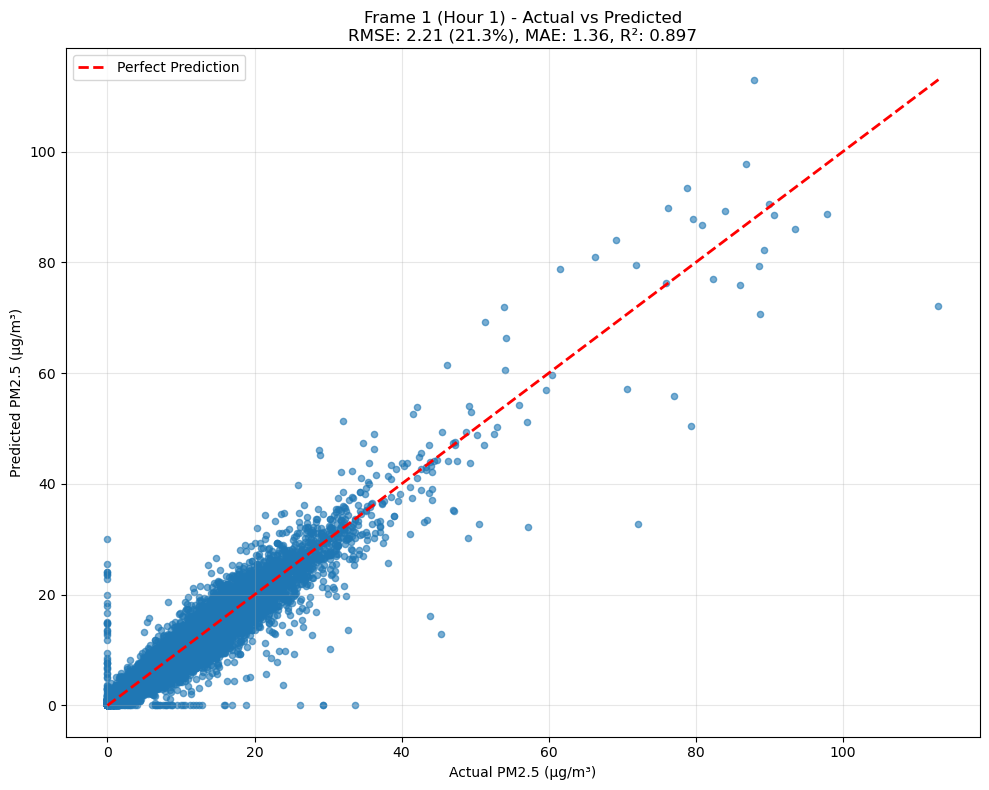


🎯 Hour 2 Scatter Plot


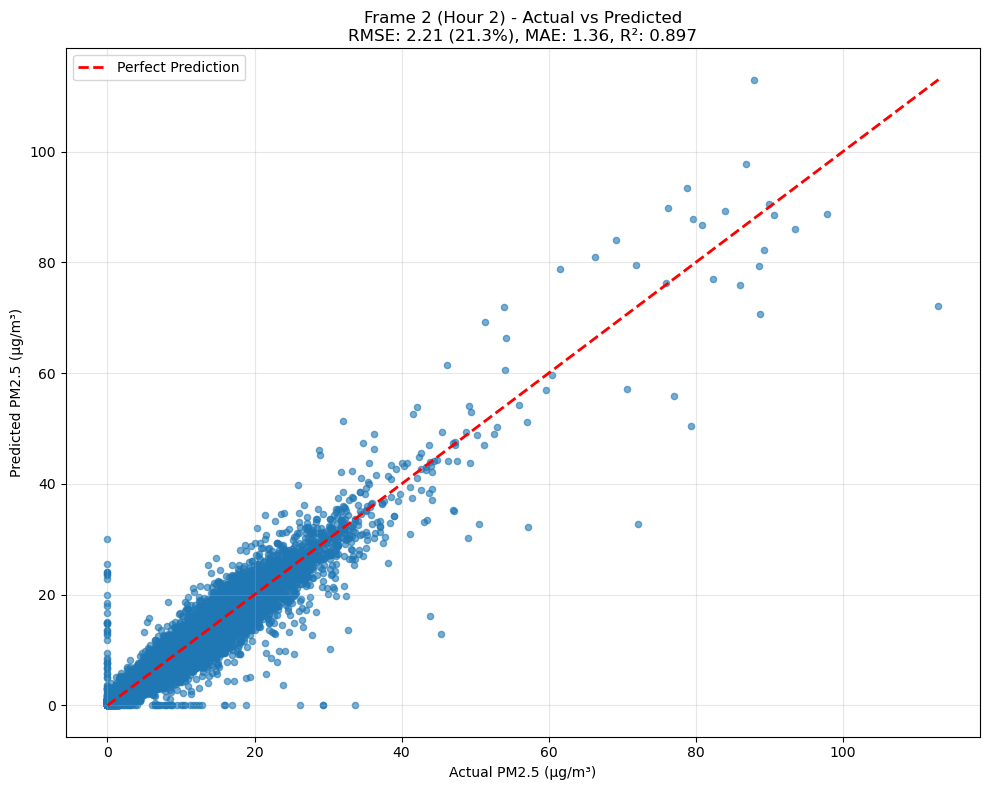


🎯 Hour 3 Scatter Plot


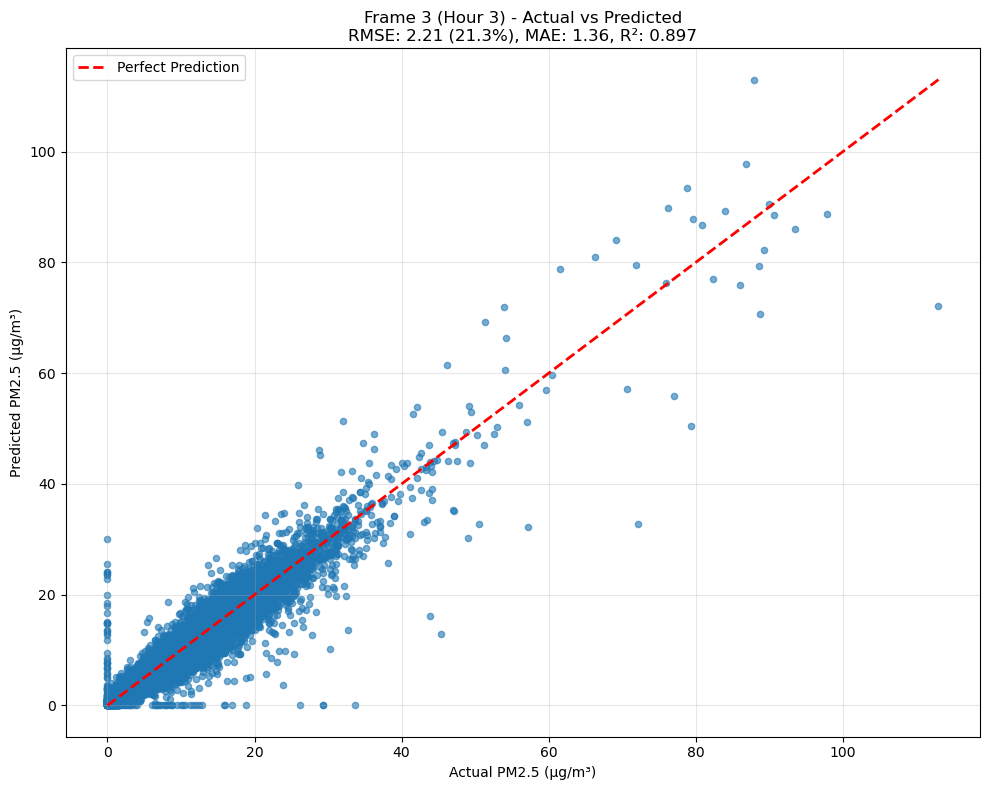


🎯 Hour 4 Scatter Plot


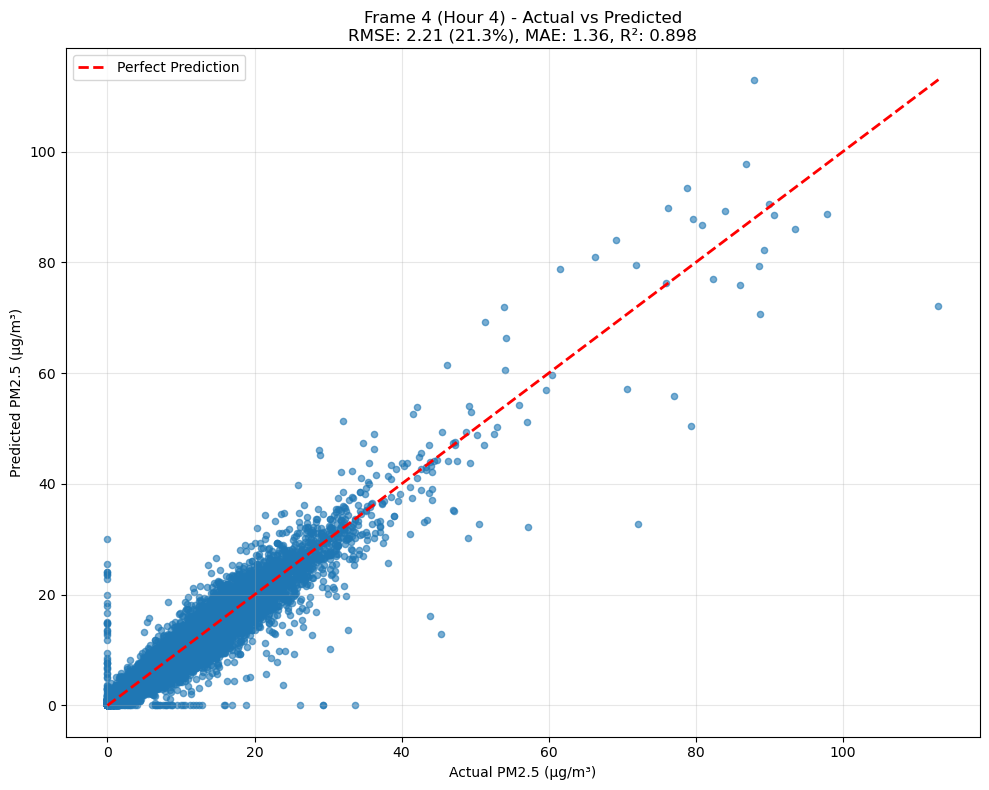


🎯 Hour 5 Scatter Plot


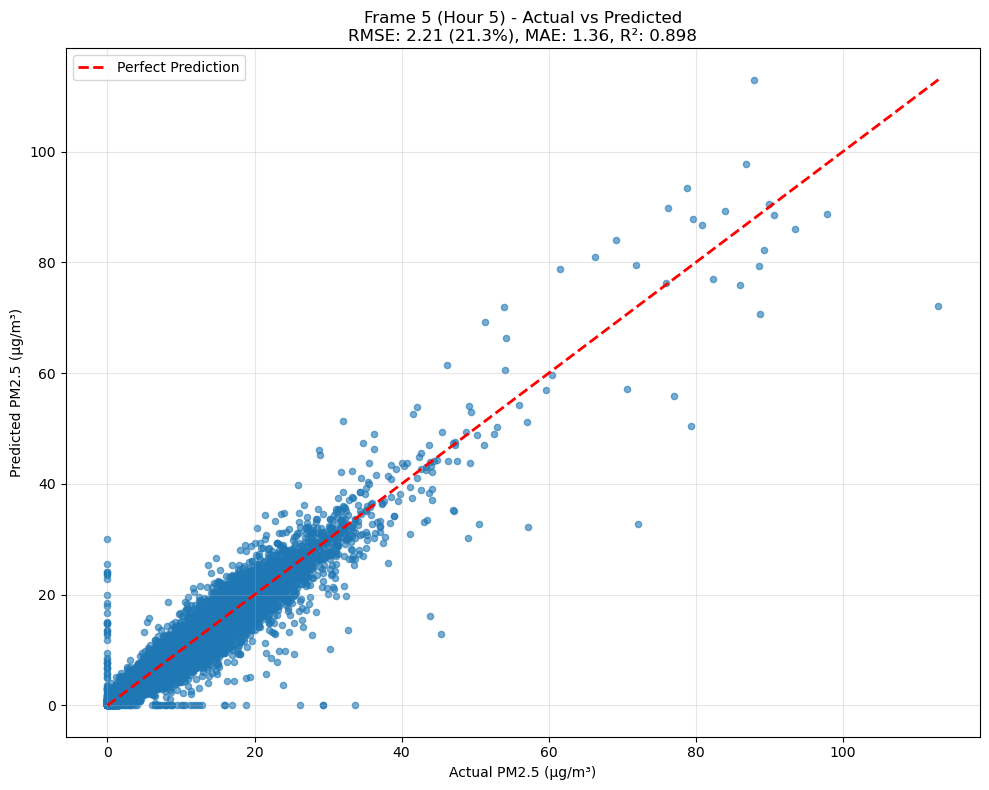

📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.206 (21.3%)   │   MAE:  1.364   │   R²:  0.897              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Simi Valley - Cochran St │1.24   │17.7  %│0.93   │0.885  │7.0    │7.0   
Reseda                   │1.87   │20.2  %│1.34

In [7]:
# shift by one pred; what if the predictions were just copying the last frame?
Y_test_shifted = np.concatenate((Y_test[[0]], Y_test[:len(Y_test)-1]), axis=0)
print(Y_test_shifted.shape, Y_test.shape)
print(Y_test_shifted[2])
print(Y_test[1])
comprehensive_frame_analysis(Y_test_shifted, Y_test, sensor_names)

# Hourly expected change

In [8]:
# hourly change = gap between the previous frame and next frame
from libs.plotting import mae, nrmse
# the average pm2.5 difference between last frame and next frame
print(f"{mae(Y_test_shifted, Y_test):.2f} micrograms per meter cubed")
# note that rmse (thus nrmse) punishes values farther away; it's not saying "x% difference"
print(f"{nrmse(Y_test_shifted, Y_test):.2f}%")

1.36 micrograms per meter cubed
21.26%


This seems low in comparison to rmse, but it's expected; the difference between 10 and 11 pm2.5 is just one, but results in a gap of 10%

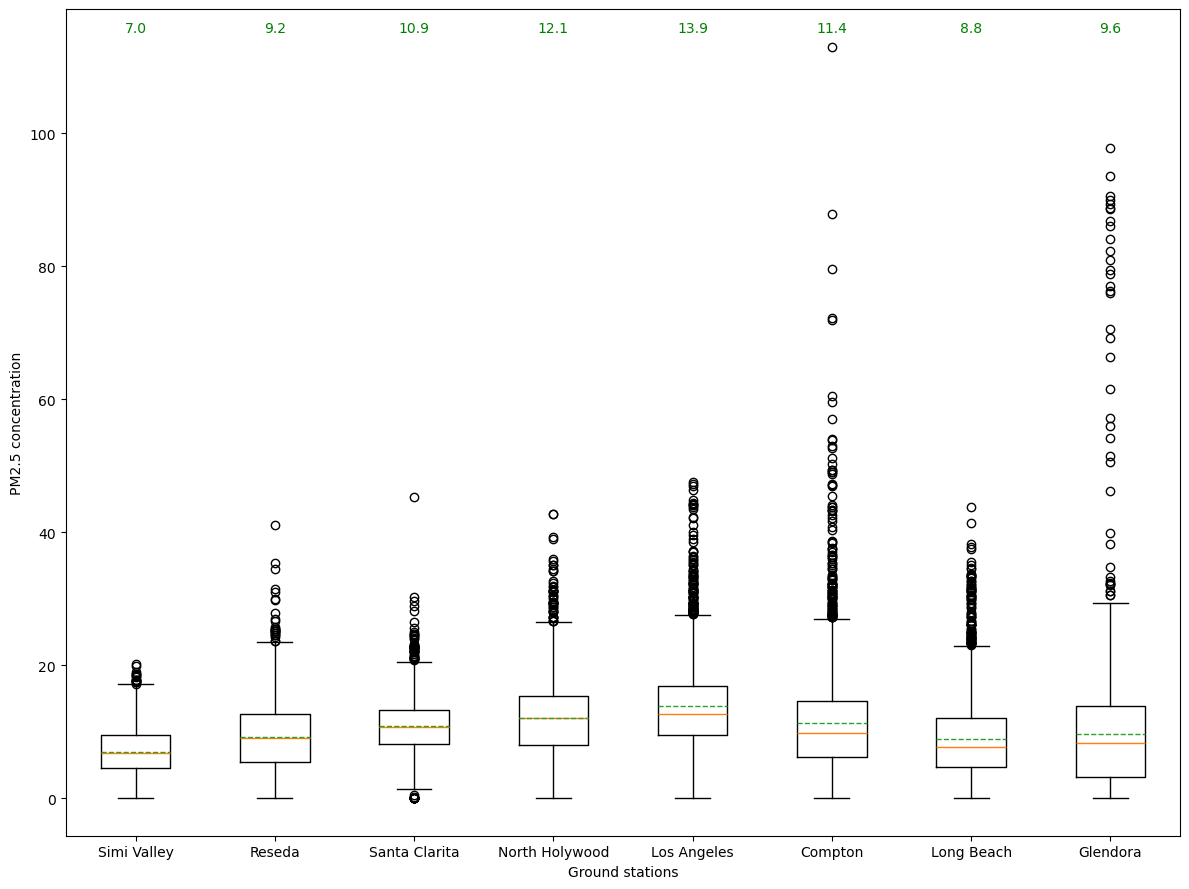

In [9]:
fig = plt.figure(figsize =(12, 9))
trimmed_sensor_names = [
    'Simi Valley', 'Reseda', 'Santa Clarita', 'North Holywood', 
    'Los Angeles', 'Compton', 'Long Beach', 'Glendora'
]
bp = plt.boxplot(
    Y_test[:,0,:], 
    tick_labels=trimmed_sensor_names, 
    meanline=True, 
    showmeans=True
)

# collect means and put them on the top row
upper_bound_text = np.max(Y_test) + 1.75
for i, mean in enumerate([mean.get_ydata()[0] for mean in bp['means']]):
    plt.text(i+1, upper_bound_text, f"{mean:.1f}", ha='center', va='bottom', color='green')
plt.ylabel("PM2.5 concentration")
plt.xlabel("Ground stations")
plt.tight_layout()
plt.show()

In [10]:
# Step 1: Compute Q1 and Q3
Q1 = np.percentile(Y_test, 25)
Q3 = np.percentile(Y_test, 75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Compute outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify and count outliers
outliers = Y_test[(Y_test < lower_bound) | (Y_test > upper_bound) | (Y_test == 0)]

outlier_count = len(outliers)
print(f"{outlier_count / np.prod(Y_test.shape) * 100:.2f}%")

7.45%
